# Gradient and Coordinate descent algorithms

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from collections import defaultdict


import matplotlib.pyplot as plt

%matplotlib inline

# Setup Seaborn
sns.set(rc={"figure.figsize": (10, 8), "font.size": 11})
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.0, rc={"lines.linewidth": 2.5})

In [2]:
# An example quadratic problem
class QuadProblem:
    def __init__ (self, a, b, c, x10, x20):
        self.a = a
        self.b = b
        self.c = c
        self.x10 = x10
        self.x20 = x20
        
    def __call__(self, x1, x2):
        return self.a * (x1 - self.x10)**2 + self.b * (x2 - self.x20)**2 + self.c * x1 * x2
        
    def minpt(self):
        """ Exact minimum """
        x1Min = (self.x10 - 0.5 * self.c * self.x20 / self.a) / (1 - 0.25 * self.c**2 / (self.a * self.b))
        x2Min = (self.x20 - 0.5 * self.c * self.x10 / self.b) / (1 - 0.25 * self.c**2 / (self.a * self.b))
        Lmin = self.a * (x1Min - self.x10)**2 + self.b * (x2Min - self.x20)**2 + self.c * x1Min*x2Min
        
        return x1Min, x2Min, Lmin
    
    def grads(self, x1cur, x2cur):
        """ Return gradients """
        dLx = 2 * self.a * (x1cur - self.x10) + self.c * x2cur
        dLy = 2 * self.b * (x2cur - self.x20) + self.c * x1cur
        
        return [dLx, dLy]
    
    def updateGD(self, curLoss, x1cur, x2cur, alpha):
        """ Update loss function by grad descent """
        d = self.grads(x1cur, x2cur)
        x1new = x1cur - alpha * d[0]
        x2new = x2cur - alpha * d[1]
        
        newLoss = self.__call__(x1new, x2new)
        return x1new, x2new, newLoss

    def updateBT(self, curLoss, x1cur, x2cur, alpha, beta):
        """ Update loss function by grad descent  backtracing line search"""
        d = self.grads(x1cur, x2cur)
        step = 1.0
        while True:
            x1new = x1cur - step * d[0]
            x2new = x2cur - step * d[1]
            term1 = self.__call__(x1new, x2new)
            term2 = self.__call__(x1cur, x2cur) - alpha * step * (d[0]**2 + d[1]**2)
            if term1 > term2:
                step = step * beta
            else:
                x1new = x1cur - step * d[0]
                x2new = x2cur - step * d[1]
                break
            
        newLoss = self.__call__(x1new, x2new)
        return x1new, x2new, newLoss
        
    def updateCD(self, curLoss, x1cur, x2cur, updateCoord):
        """ Update by coordinate descent """
        if updateCoord == 0:
            # Update x1
            x1new = -0.5 * self.c * x2cur / self.a  + self.x10
            x2new = x2cur
        else:
            # Update x2
            x2new = -0.5 * self.c * x1cur / self.b + self.x20
            x1new = x1cur
            
        newLoss = self.__call__(x1new, x2new)
        return x1new, x2new, newLoss  

In [3]:
# Initiate the problem and the mesh for plots
x1 = np.linspace(-5,5,200)
x2 = np.linspace(-5,5,200)
X1, X2 = np.meshgrid(x1, x2)

#Q = QuadProblem(a = 0.5, b = 0.1, c = -0.2, x10 = 0.1, x20 = -0.3)
Q = QuadProblem(a = 0.5, b = 0.1, c = -0.2, x10 = 1.0, x20 = -0.5)
x1Min, x2Min, Lmin = Q.minpt() # True minum

In [4]:
# -- Minimize by gradient descent

# Initiate
alpha0 = 0.3
maxIter = 200
x1Start, x2Start = 2.5,2
x1cur, x2cur = x1Start, x2Start
loss0 = Q(x1cur, x2cur)
data = defaultdict(list)

for i in range(maxIter):
    ds = Q.grads(x1cur, x2cur) # derivatives
    data['x1'].append(x1cur)
    data['x2'].append(x2cur)
    data['dx1'].append(-ds[0]*alpha0)
    data['dx2'].append(-ds[1]*alpha0)
    
    x1cur, x2cur, newLoss = Q.updateGD(curLoss = loss0, x1cur = x1cur, x2cur = x2cur, alpha = alpha0)
    
    # Check conv
    if np.abs(loss0 - newLoss) < 1e-5:
        print("Convergence achieved in {:d} iterations (alpha={:.2f})".format(i+1, alpha0))
        print("x1min, x2min = [{:.4f},{:.4f}]".format(x1cur,x2cur))
        break
        
    loss0 = newLoss
    
if i == maxIter-1:
    print("Convergence not achieved after {:d} iterations".format(maxIter))  

Convergence achieved in 82 iterations (alpha=0.30)
x1min, x2min = [1.1331,0.6593]


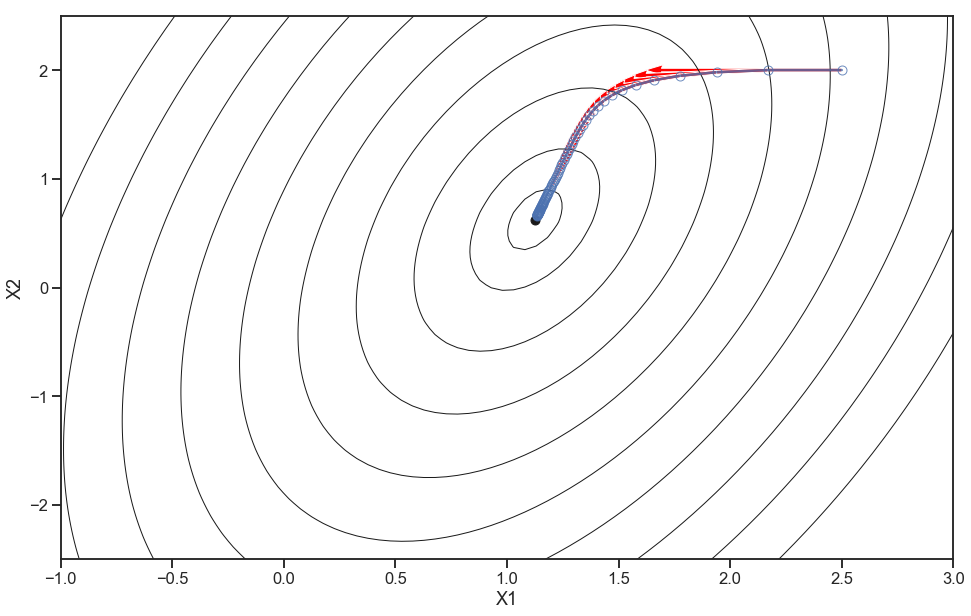

In [5]:
fig, ax = plt.subplots(figsize=(16,10))
levels = np.power(np.linspace(0,1.5,10),2.)

CS = ax.contour(X1, X2, Q(X1,X2), levels, colors='k',linewidths=1, linestyles="-")
ax.plot(x1Min, x2Min,'ko')
ax.set_xlim([-1,3])
ax.set_ylim([-2.5,2.5])
plt.quiver(data['x1'],data['x2'], data['dx1'],data['dx2'], width=0.004, scale=1.5, angles='xy',
           color="red", linewidths=1)
plt.plot(data['x1'],data['x2'], 'o', linestyle = '-', fillstyle='none', alpha=0.8)
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()
#plt.savefig("grad_descent.pdf")



In [6]:
# -- Minimize by gradient descent and back tracing line search

# Initiate
maxIter = 200
x1Start, x2Start = 2.5,2
x1cur, x2cur = x1Start, x2Start
loss0 = Q(x1cur, x2cur)
data = defaultdict(list)

for i in range(maxIter):
    ds = Q.grads(x1cur, x2cur) # derivatives
    data['x1'].append(x1cur)
    data['x2'].append(x2cur)
    data['dx1'].append(-ds[0])
    data['dx2'].append(-ds[1])
    
    x1cur, x2cur, newLoss = Q.updateBT(curLoss = loss0, x1cur = x1cur, x2cur = x2cur, alpha = 0.5, beta=0.5)
    
    # Check conv
    if np.abs(loss0 - newLoss) < 1e-5:
        print("Convergence achieved in {:d} iterations)".format(i+1))
        print("x1min, x2min = [{:.4f},{:.4f}]".format(x1cur,x2cur))
        break
        
    loss0 = newLoss
    
if i == maxIter-1:
    print("Convergence not achieved after {:d} iterations".format(maxIter))  

Convergence achieved in 28 iterations)
x1min, x2min = [1.1290,0.6419]


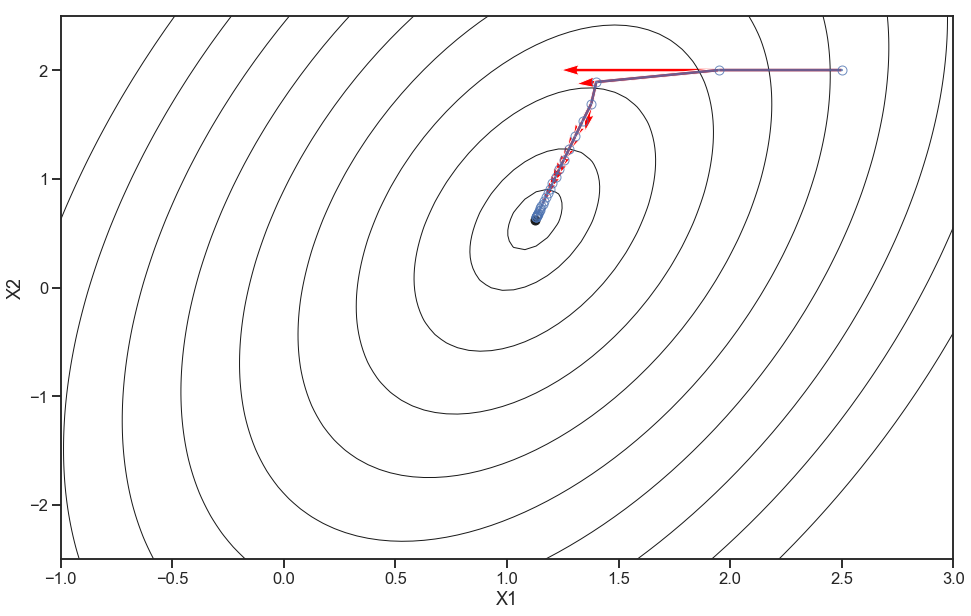

In [7]:
fig, ax = plt.subplots(figsize=(16,10))
levels = np.power(np.linspace(0,1.5,10),2.)

CS = ax.contour(X1, X2, Q(X1,X2), levels, colors='k',linewidths=1, linestyles="-")
ax.plot(x1Min, x2Min,'ko')
ax.set_xlim([-1,3])
ax.set_ylim([-2.5,2.5])
plt.quiver(data['x1'],data['x2'], data['dx1'],data['dx2'], width=0.004, scale=3.5, angles='xy',
           color="red", linewidths=1)
plt.plot(data['x1'],data['x2'], 'o', linestyle = '-', fillstyle='none', alpha=0.8)
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [8]:
# -- Minimize by coordinate descent
# Initiate
alpha0 = 0.3
x1Start, x2Start = 2.5,2
x1cur, x2cur = x1Start, x2Start
loss0 = Q(x1cur, x2cur)

dataCD = defaultdict(list)


for i in range(maxIter):
    dataCD['x1'].append(x1cur)
    dataCD['x2'].append(x2cur)
    
    # Update
    if i % 2 == 0:
        x1cur, x2cur, newLoss = Q.updateCD(curLoss=loss0, x1cur=x1cur, x2cur=x2cur, updateCoord=0)
    else:
        x1cur, x2cur, newLoss = Q.updateCD(curLoss=loss0, x1cur=x1cur, x2cur=x2cur, updateCoord=1)

    
    # Check conv
    if np.abs(loss0 - newLoss) < 1e-5:
        print("Convergence achieved in {:d} iterations".format(i+1))
        print("x1min, x2min = [{:.4f},{:.4f}]".format(x1cur,x2cur))
        break
    loss0 = newLoss
    
if i == maxIter-1:
    print("Convergence not achieved after {:d} iterations".format(maxIter))  

Convergence achieved in 8 iterations
x1min, x2min = [1.1272,0.6272]


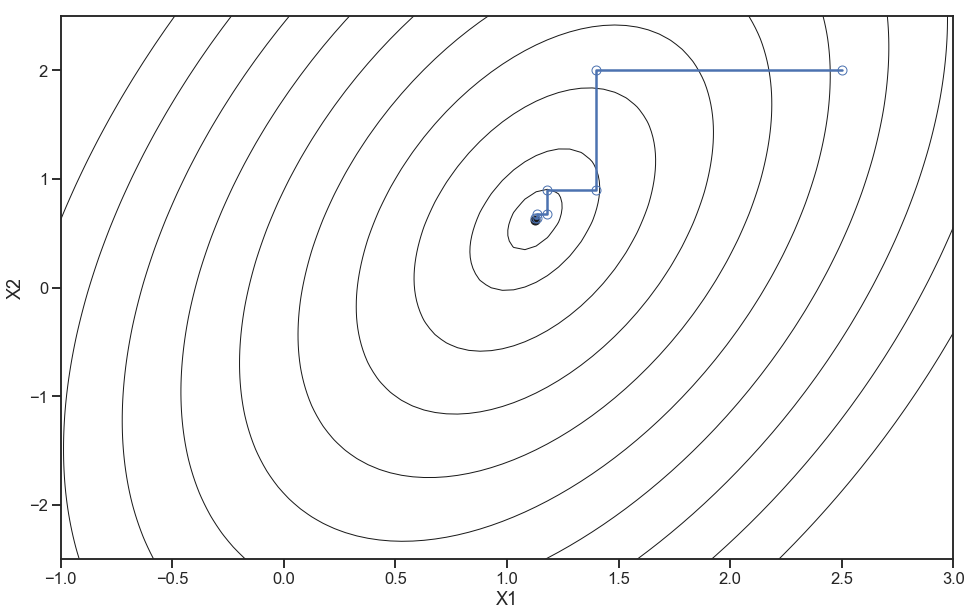

In [13]:
fig, ax = plt.subplots(figsize=(16,10))
#levels = np.power(np.linspace(0,2,10),2.5)
levels = np.power(np.linspace(0,1.5,10),2.)

CS = ax.contour(X1, X2, Q(X1,X2), levels, colors='k',linewidths=1, linestyles="-")
ax.plot(x1Min, x2Min,'ko')
ax.set_xlim([-1,3])
ax.set_ylim([-2.5,2.5])
plt.plot(dataCD['x1'],dataCD['x2'], 'o', linestyle = '-', fillstyle='none', label = "Coordinate Descent Path")
#plt.legend()
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()
#plt.savefig("coord_descent")

## L2 penalty term

Add a $L_2$ norm term to the quadratic problem:

In [14]:
class L2Problem(QuadProblem):
    def __init__(self, a, b, c, x10, x20, l2):
        super().__init__(a, b, c, x10, x20)
        self.l2 = l2
    
    def __call__(self, x1, x2):
        return super().__call__(x1, x2) + self.l2 * (x1*x1 + x2*x2)
        
    def minpt(self):
        """ Exact minimum """
        x1Min = (self.x10 * (1.0 + self.l2/self.b) - 0.5 * self.c * self.x20 / self.a)\
              / ((1.0 + self.l2/self.a) * (1.0 + self.l2/self.b) - 0.25 * self.c**2 / (self.a * self.b))
        
        x2Min = (self.x20 * (1.0 + self.l2/self.a) - 0.5 * self.c * self.x10 / self.b)\
              / ((1.0 + self.l2/self.a) * (1.0 + self.l2/self.b) - 0.25 * self.c**2 / (self.a * self.b))
        
        Lmin = self.a * (x1Min - self.x10)**2 + self.b * (x2Min - self.x20)**2 + self.c * x1Min*x2Min \
             + self.l2 * (x1Min**2 + x2Min**2)
        
        return x1Min, x2Min, Lmin
    
    def grads(self, x1cur, x2cur):
        """ Return gradients """
        grads = super().grads(x1cur, x2cur)
        grads[0] += 2.0 * self.l2 * x1cur
        grads[1] += 2.0 * self.l2 * x2cur
        
        return grads
    
    def updateGD(self, curLoss, x1cur, x2cur, alpha):
        """ Update loss function by grad descent """
        d = self.grads(x1cur, x2cur)
        x1new = x1cur - alpha * d[0]
        x2new = x2cur - alpha * d[1]
        
        newLoss = self.__call__(x1new, x2new)
        return x1new, x2new, newLoss
        
    def updateCD(self, curLoss, x1cur, x2cur, updateCoord):
        """ Update by coordinate descent """
        if updateCoord == 0:
            # Update x1
            x1new = -0.5 * (self.c * x2cur / self.a + self.l2)  + self.x10
            x2new = x2cur
        else:
            # Update x2
            x2new = -0.5 * (self.c * x1cur / self.b + self.l2) + self.x20
            x1new = x1cur
            
        newLoss = self.__call__(x1new, x2new)
        return x1new, x2new, newLoss  

In [15]:
# Initiate the problem and the mesh for plots
x1 = np.linspace(-5,5,200)
x2 = np.linspace(-5,5,200)
X1, X2 = np.meshgrid(x1, x2)

Q2 = L2Problem(a = 0.5, b = 0.1, c = -0.2, x10 = 1.0, x20 = -0.5, l2=0.1)
x1Min2, x2Min2, Lmin = Q2.minpt() # True minum

In [16]:
# -- Minimize by gradient descent

# Initiate
alpha0 = 0.1
maxIter = 200
x1Start, x2Start = 2.5,2
x1cur, x2cur = x1Start, x2Start
loss0 = Q2(x1cur, x2cur)
data = defaultdict(list)

for i in range(maxIter):
    ds = Q2.grads(x1cur, x2cur) # derivatives
    data['x1'].append(x1cur)
    data['x2'].append(x2cur)
    data['dx1'].append(-ds[0]*alpha0)
    data['dx2'].append(-ds[1]*alpha0)
    
    x1cur, x2cur, newLoss = Q2.updateGD(curLoss = loss0, x1cur = x1cur, x2cur = x2cur, alpha = alpha0)

    # Check conv
    if np.abs(loss0 - newLoss) < 1e-5:
        print("Convergence achieved in {:d} iterations (alpha={:.2f})".format(i+1, alpha0))
        print("x1min, x2min = [{:.4f},{:.4f}]".format(x1cur,x2cur))
        break
        
    loss0 = newLoss
    
if i == maxIter-1:
    print("Convergence not achieved after {:d} iterations".format(maxIter))  

Convergence achieved in 122 iterations (alpha=0.10)
x1min, x2min = [0.8698,0.2079]


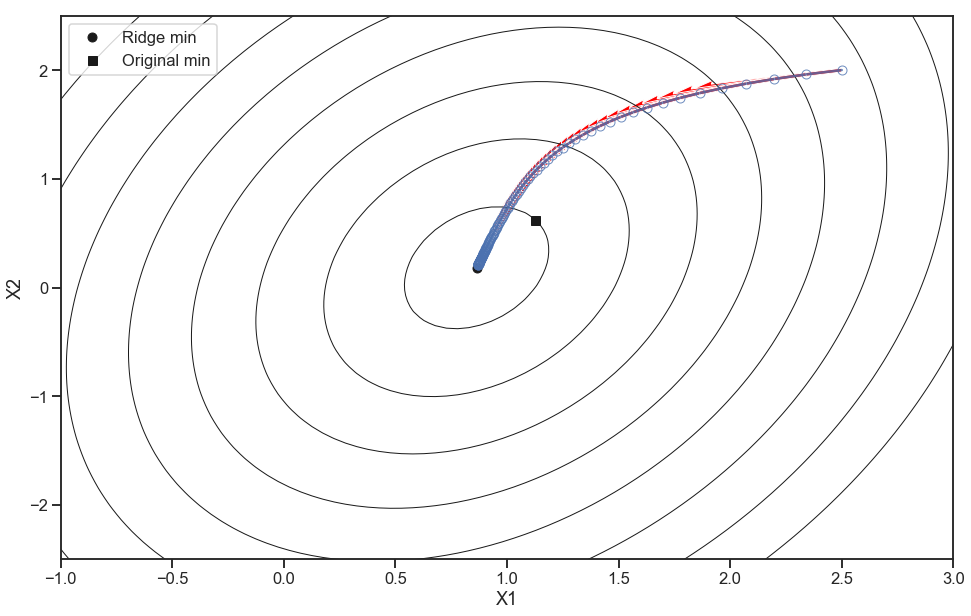

In [18]:
fig, ax = plt.subplots(figsize=(16,10))
levels = np.power(np.linspace(0,1.8,10),2.)

CS = ax.contour(X1, X2, Q2(X1,X2), levels, colors = 'k', linewidths=1, linestyles="-")
ax.plot(x1Min2, x2Min2,'ko',label="Ridge min")
ax.plot(x1Min, x2Min,'ks',label="Original min")
ax.set_xlim([-1,3])
ax.set_ylim([-2.5,2.5])
plt.quiver(data['x1'],data['x2'], data['dx1'],data['dx2'], width=0.004, scale=1.0, angles='xy',
           color="red", linewidths=1)
plt.plot(data['x1'],data['x2'], 'o', linestyle = '-', fillstyle='none', alpha=0.8)
plt.legend()
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()


Why does the gradients point in strange directions?

In [19]:
print("Original min: [{:.2f}, {:.2f}]".format(x1Min, x2Min))
print("Original min: [{:.2f}, {:.2f}]".format(x1Min2, x2Min2))

Original min: [1.13, 0.62]
Original min: [0.86, 0.18]


## L1 penalty term

In [20]:
# An example quadratic problem
class L1Problem:
    def __init__ (self, a, b, c, x10, x20, l1):
        self.a = a
        self.b = b
        self.c = c
        self.x10 = x10
        self.x20 = x20
        self.l1 = l1
        
    def __call__(self, x1, x2):
        L0 =self.a * (x1 - self.x10)**2 + self.b * (x2 - self.x20)**2 + self.c * x1 * x2
        L1 = self.l1 * (np.abs(x1) + np.abs(x2))
        return L0 + L1
        
    def updateCD(self, curLoss, x1cur, x2cur, updateCoord):
        """ Update by coordinate descent """
        
        if updateCoord == 0:
            # Update x1
            z = 2.0 * self.a * self.x10 - self.c * x2cur
            if np.abs(z) > self.l1 and z > 0:
                x1new = self.x10 - 0.5 * self.c *x2cur / self.a - 0.5 * self.l1 / self.a
            elif np.abs(z) > self.l1 and z < 0:
                x1new = self.x10 - 0.5 * self.c *x2cur / self.a + 0.5 * self.l1 / self.a
            else:
                x1new = 0            
            x2new = x2cur
        else:
            # Update x2
            z = 2.0 * self.b * self.x20 - self.c * x1cur
            if np.abs(z) > self.l1 and z > 0:
                x2new = self.x20 - 0.5 * self.c *x1cur / self.b - 0.5 * self.l1 / self.b
            elif np.abs(z) > self.l1 and z < 0:
                x2new = self.x20 - 0.5 * self.c *x1cur / self.b + 0.5 * self.l1 / self.b
            else:
                x2new = 0  
            x1new = x1cur
            
        newLoss = self.__call__(x1new, x2new)
        
        return x1new, x2new, newLoss  

In [21]:
# Initiate the problem and the mesh for plots
x1 = np.linspace(-5,5,200)
x2 = np.linspace(-5,5,200)
X1, X2 = np.meshgrid(x1, x2)

Q1 = L1Problem(a = 0.5, b = 0.1, c = -0.2, x10 = 1.0, x20 = -0.5, l1=0.1)

In [22]:
# -- Minimize by coordinate descent
# Initiate
x1Start, x2Start = 2.5,2
x1cur, x2cur = x1Start, x2Start
loss0 = Q1(x1cur, x2cur)

dataCD = defaultdict(list)

for i in range(maxIter):
    dataCD['x1'].append(x1cur)
    dataCD['x2'].append(x2cur)
    
    # Update
    if i % 2 == 0:
        x1cur, x2cur, newLoss = Q1.updateCD(curLoss=loss0, x1cur=x1cur, x2cur=x2cur, updateCoord=0)
    else:
        x1cur, x2cur, newLoss = Q1.updateCD(curLoss=loss0, x1cur=x1cur, x2cur=x2cur, updateCoord=1)
    
    # Check conv
    if np.abs(loss0 - newLoss) < 1e-5:
        print("Convergence achieved in {:d} iterations".format(i+1))
        print("x1min, x2min = [{:.4f},{:.4f}]".format(x1cur,x2cur))
        break
    loss0 = newLoss
    
if i == maxIter-1:
    print("Convergence not achieved after {:d} iterations".format(maxIter))  

Convergence achieved in 6 iterations
x1min, x2min = [0.9000,0.0000]


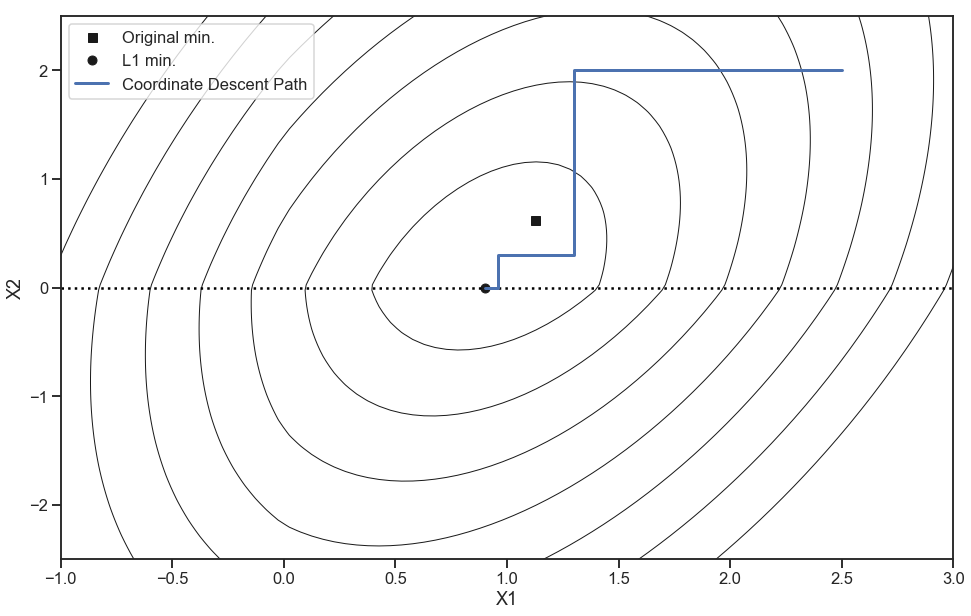

In [23]:
fig, ax = plt.subplots(figsize=(16,10))
levels = np.power(np.linspace(0,1.5,10),2.)

CS = ax.contour(X1, X2, Q1(X1,X2), levels, colors='k',linewidths=1, linestyles="-")
ax.plot(x1Min, x2Min,'ks',label="Original min.")
ax.plot(x1cur, x2cur,'ko',label="L1 min.")
ax.axhline(0,linestyle=":", color="black")
ax.set_xlim([-1,3])
ax.set_ylim([-2.5,2.5])
plt.plot(dataCD['x1'],dataCD['x2'], linewidth=3, linestyle='-', label = "Coordinate Descent Path")
plt.legend()
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [24]:
print("Original min: [{:.2f}, {:.2f}]".format(x1Min, x2Min))
print("L1 min: [{:.2f}, {:.2f}]".format(x1cur, x2cur))

Original min: [1.13, 0.62]
L1 min: [0.90, 0.00]


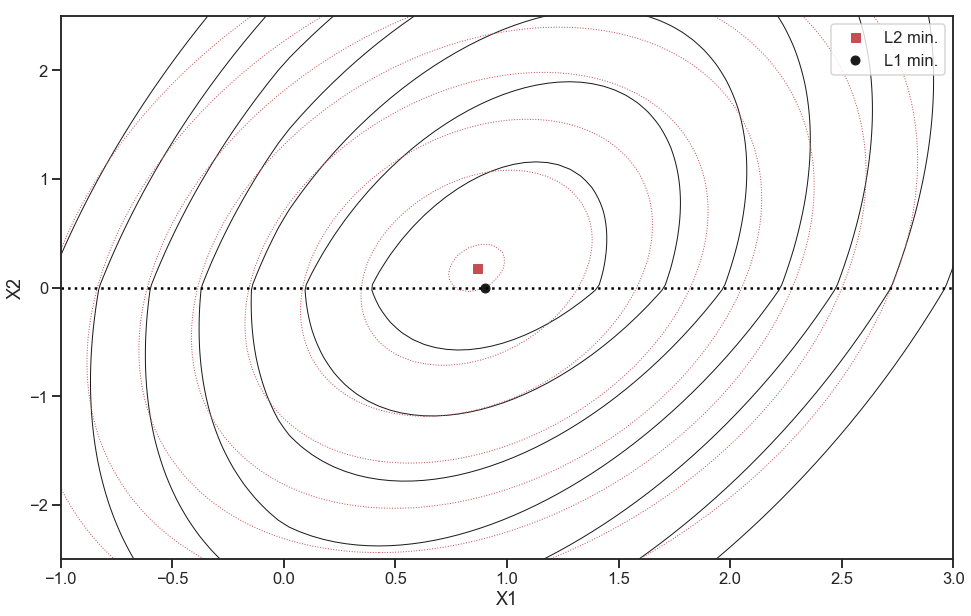

In [25]:
fig, ax = plt.subplots(figsize=(16,10))
levels = np.power(np.linspace(0,1.5,10),2.)

CS_1 = ax.contour(X1, X2, Q1(X1,X2), levels, colors='k',linewidths=1, linestyles="-")
CS_2 = ax.contour(X1, X2, Q2(X1,X2), levels, colors='r',linewidths=1, linestyles=":")

ax.plot(x1Min2, x2Min2,'rs',label="L2 min.")
ax.plot(x1cur, x2cur,'ko',label="L1 min.")
ax.axhline(0,linestyle=":", color="black")
ax.set_xlim([-1,3])
ax.set_ylim([-2.5,2.5])
plt.legend()
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()
#plt.savefig("L1_vs_L2.pdf")